In [1]:
from ag3 import release_data
v3 = release_data()

In [2]:
import pandas as pd
import numpy as np
import allel
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
# kubernetes cluster setup
n_workers = 5
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.scale_up(n_workers)
#cluster.adapt(minimum=1, maximum=n_workers)
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.32.38.65:46315
distributed.scheduler - INFO -   dashboard at:                     :8787


In [5]:
# dask client setup
from dask.distributed import Client, progress
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-59cd3412-d0ad-11ea-88bd-aed81f36a029
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.38.65:46315 Dashboard: /user/nicholasharding/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
genome = {
    "2R": 61545105,
    "3R": 53200684,
    "2L": 49364325,
#    "UNKN": 42389979,
    "3L": 41963435,
    "X": 24393108,
#    "Y_unplaced": 237045,
#    "Mt": 15363
}

In [7]:
window_size = 100_000

In [8]:
cached_fn = Path(f"accessibility_summary_{str(window_size)}.csv")

In [9]:
if not cached_fn.is_file():
    accessibility_stats = {}
    # accessibility
    # load_mask
    for chrom in ["2R", "2L", "3R", "3L", "X"]:

        if chrom in accessibility_stats:
            continue

        pos = allel.SortedIndex(v3.load_variants(chrom))

        windows = allel.stats.window.position_windows(pos, size=window_size, start=1, stop=pos[-1], step=window_size)
        windows = list(windows)
        df = pd.DataFrame(windows, columns=["start", "stop"])

        win_size = df["stop"] - df["start"] + 1

        for mask in "gamb_colu", "arab", "gamb_colu_arab":

            mask_a = v3.load_mask(chrom, mask)
            out, windows, counts = allel.windowed_statistic(pos, mask_a, np.sum, windows=windows)
            df[mask] = out / win_size

        accessibility_stats[chrom] = df

    all_df = pd.concat(accessibility_stats)
    all_df.to_csv(cached_fn)
    
else:
    all_df = pd.read_csv(cached_fn, index_col=[0, 1])

In [10]:
autosomes = '2R', '2L', '3R', '3L'
chromosomes = autosomes + ('X',)

class GenomeFigure(object):
    
    def __init__(self, genome, *args, **kwargs):
        self.chromosomes = kwargs.pop('chromosomes', ['2R', '2L', '3R', '3L', 'X'])
        maxchrsize = max(genome[chrom] for chrom in self.chromosomes)
        fig = plt.figure(*args, **kwargs)
        self.fig = fig
        self.ax = dict()
        for i, chrom in enumerate(self.chromosomes):
            ax = fig.add_subplot(3, 2, i+1)
            self.ax[chrom] = ax
            S = np.arange(1, genome[chrom], 1, dtype=np.int64)
            if i % 2 == 1:
                sns.despine(ax=ax, offset=10, top=True, left=True, right=False)
                ax.set_xlim(0, maxchrsize)
                ax.yaxis.tick_right()
                ax.yaxis.set_label_position('right')
            else:
                ax.set_xlim((S.size)-(maxchrsize), S.size)
                ax.yaxis.tick_left()
                sns.despine(ax=ax, offset=10, top=True, left=False, right=True)
            ax.set_xticks(range(0, S.size, int(5e6)))
            ax.set_xticklabels(range(0, int(S.size/1e6), 5))
            ax.set_title(chrom, fontweight='bold')
            ax.xaxis.tick_bottom()
        fig.tight_layout()
        
    def apply(self, f, **kwargs):
        chromosomes = kwargs.pop('chromosomes', self.chromosomes)
        for chrom in chromosomes:
            ax = self.ax[chrom]
            f(chrom, ax, **kwargs)
        
        
def subplots(*args, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    sns.despine(ax=ax, offset=10)
    return fig, ax

In [12]:
from matplotlib.ticker import MultipleLocator

In [13]:
def plot_accessibility_summary(chrom, ax, species="gamb_colu", **kwargs):
    
    x = all_df.loc[chrom].start.values    
    y = all_df.loc[chrom][species]
    ax.plot(x, y)
    ax.set_ylim([0, 1])
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    

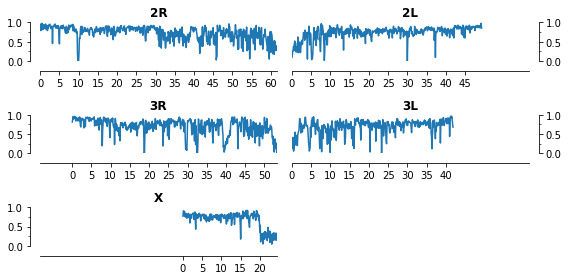

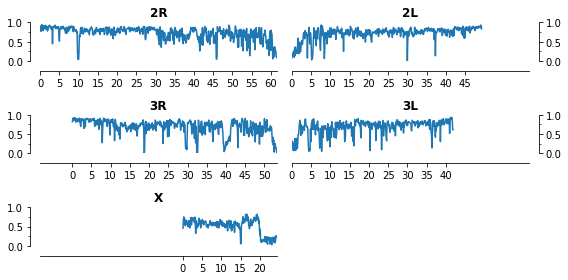

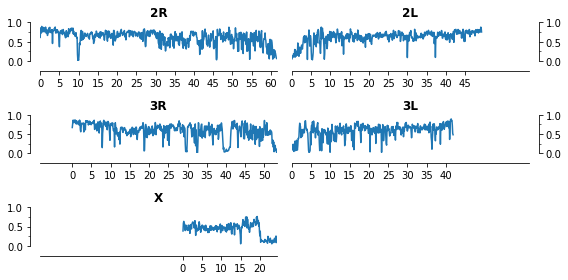

distributed.scheduler - INFO - Register tcp://10.35.63.225:36461
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.63.225:36461
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.121.4:37403
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.121.4:37403
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.90.5:33687
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.90.5:33687
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.123.3:42905
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.123.3:42905
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.89.5:32921
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.89.5:32921
distributed.cor

In [14]:
for species_id in ["gamb_colu", "arab", "gamb_colu_arab"]:

    g = GenomeFigure(genome, figsize=(8, 4))
    g.apply(plot_accessibility_summary, species=species_id)

    g.fig.savefig(f"../content/images/genomewide_accesibility_{species_id}.svg")